Import Necessary Libraries: First, you'll need to import the libraries we'll be using. For image processing and machine learning, we'll use libraries like TensorFlow/Keras and OpenCV.


In [ ]:
!pip install opencv-python
#!pip install -U tensorflow

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
def load_data(data_dir):
    images = []
    labels = []
    label_names = sorted(os.listdir(data_dir))
    label_map = {label: idx for idx, label in enumerate(label_names)}
    
    for label in label_names:
        label_dir = os.path.join(data_dir, label)
        for img_file in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_file)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (128, 128))  # Resize images to a uniform size
                images.append(img)
                labels.append(label_map[label])
    
    return np.array(images), np.array(labels), label_map

Load training and validation data. We split dataset into train and valid.

In [ ]:
train_dir = '/home/datascience/kaggle/new_plant_disease_dataset_augmented/new_plant_disease_dataset_augmented/train'
val_dir = '/home/datascience/kaggle/new_plant_disease_dataset_augmented/new_plant_disease_dataset_augmented/valid'

In [ ]:
X_train, y_train, label_map = load_data(train_dir)
X_val, y_val, _ = load_data(val_dir)


# Print the first 5 images and their labels
for i in range(5):
    plt.imshow(X_train[i])
    plt.title(f"Label: {list(label_map.keys())[y_train[i]]}")
    plt.axis('off')
    plt.show()

Normalize pixel values so that you have model learn faster and perform better

In [ ]:
# Normalize pixel values
X_train = X_train / 255.0
X_val = X_val / 255.0

Convert labels to one-hot encoding. So that machine algorithm understand the data

In [ ]:

y_train = to_categorical(y_train, num_classes=len(label_map))
y_val = to_categorical(y_val, num_classes=len(label_map))

Perform data augmentation

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

Build the CNN model

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_map), activation='softmax')
])
#1 layer of convolution 2d with 32 filters 3x3 kernal size
#max pooling layer - maximum values of the feature map
#flatten turns into an array
#dense is when we feed it into the neura lnetwork
#dropout - turns off filters in layer to minimize overfitting
#dense(len) = output layer - have softmax b/c we have multiclass classification
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Now Set up TensorBoard and train the model

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
import datetime
import math

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), 
                    steps_per_epoch=math.ceil(len(X_train) / 32), 
                    epochs=20, 
                    validation_data=(X_val, y_val),
                    callbacks=[tensorboard_callback])

# Launch TensorBoard
%load_ext tensorboard
%tensorboard --logdir logs/fit

In [ ]:
## Save the trained model
# Save the entire model to a HDF5 file
model.save('/home/datascience/model/my_model')

In [ ]:
## Lets just process one image at a time and see what label does it predict based on the image.
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('/home/datascience/model/my_model')

# Function to preprocess the image
def preprocess_image(image_path, img_size=(128, 128)):
    img = cv2.imread(image_path)
    img = cv2.resize(img, img_size)  # Resize image
    img = img.astype('float32') / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Function to predict label for the image
def predict_label(image_path):
    img = preprocess_image(image_path)
    prediction = model.predict(img)
    predicted_label = np.argmax(prediction, axis=1)[0]
    return predicted_label

# Path to the image
image_path = '/home/datascience/kaggle/test/test/Apple___Cedar_apple_rust/Apple___Cedar_apple_rust1.jpg'

# Predict label for the image
predicted_label = predict_label(image_path)

# Print the predicted label
#print(f"Predicted Label: {list(label_map.keys())[predicted_label]}")

# Print the predicted label with the Image
X_test = preprocess_image(image_path)
plt.figure(figsize=(5, 25))
for i in range(1):
    # Display image
    ax = plt.subplot(5, 1, i + 1)
    plt.imshow(cv2.cvtColor((X_test[i] * 255).astype(np.uint8), cv2.COLOR_BGR2RGB))
    ax.set_title(f"Predicted Label: {list(label_map.keys())[predicted_label]}", fontsize=12, y=-0.15)
    plt.axis("off")
    plt.subplots_adjust(hspace=0.5)
plt.show()


In [ ]:
#Now lets us load all the files and show predicted label
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tabulate import tabulate

# Load the trained model
model = load_model('/home/datascience/model/my_model')

# Function to preprocess the image
def preprocess_image(image_path, img_size=(128, 128)):
    img = cv2.imread(image_path)
    img = cv2.resize(img, img_size)  # Resize image
    img = img.astype('float32') / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Function to predict label for the image
def predict_label(image_path):
    img = preprocess_image(image_path)
    prediction = model.predict(img)
    predicted_label = np.argmax(prediction, axis=1)[0]
    return predicted_label



# Function to display image with predicted label
def display_image_with_label(image_path):
    predicted_label = predict_label(image_path)
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    file_name = os.path.basename(image_path)
    plt.imshow(img_rgb)
    plt.title(f"Actual File Name: {filename}\nActual Label: {actual_label}\nPredicted Label: {list(label_map.keys())[predicted_label]}", fontsize=12, y=-0.15)
    plt.axis('off')
    plt.show()
    print(f"Actual File Name: {filename}\nActual Label: {actual_label}\nPredicted Label: {list(label_map.keys())[predicted_label]}")


# Path to the directory containing images
directory_path = '/home/datascience/kaggle/test/test'

# List to store file names and predicted labels
results = []

########### File name containts the actual label#############
## Iterate over each image in the directory and display it with the predicted label
#for filename in os.listdir(directory_path):
#    if filename.endswith(".jpg"):
#        image_path = os.path.join(directory_path, filename)
#        predicted_label = predict_label(image_path)
#results.append((filename, {list(label_map.keys())[predicted_label]}))

# Since our test data has lots of files, we need to limit the number of displays



########### Sub directory contains the actual label#############
# Iterate over each subdirectory in the directory
# Counter to limit the number of displayed images
display_count = 0
display_limit = 8

for subdir in os.listdir(directory_path):
    subdir_path = os.path.join(directory_path, subdir)
    if os.path.isdir(subdir_path):
        actual_label = subdir
        # Iterate over each image in the subdirectory
        for filename in os.listdir(subdir_path):
            if filename.endswith(".jpg"):
                image_path = os.path.join(subdir_path, filename)
                predicted_label = predict_label(image_path)
                results.append((filename, actual_label, {list(label_map.keys())[predicted_label]}))
                # Uncomment the next line to display each image with its predicted label
                if display_count < display_limit:
                    display_image_with_label(image_path)
                    display_count += 1
                # Break if the display limit is reached
                if display_count >= display_limit:
                    break
        # Break if the display limit is reached
        if display_count >= display_limit:
            break

In [ ]:
#Print the results in tabular format:

# Iterate over each subdirectory in the directory
for subdir in os.listdir(directory_path):
    subdir_path = os.path.join(directory_path, subdir)
    if os.path.isdir(subdir_path):
        actual_label = subdir
        # Iterate over each image in the subdirectory
        for filename in os.listdir(subdir_path):
            if filename.endswith(".jpg"):
                image_path = os.path.join(subdir_path, filename)
                predicted_label = predict_label(image_path)
                results.append((filename, actual_label, {list(label_map.keys())[predicted_label]}))

# Create a DataFrame from the results
df = pd.DataFrame(results, columns=['File Name','Actual Label', 'Predicted Label'])

# Display the table
#print(df)
print(tabulate(df, headers='keys', tablefmt='grid'))

In [ ]:
al = list(df["Actual Label"].tolist())
pl = list(df["Predicted Label"].tolist())

In [126]:
result_new = []

for x in range(len(al)):
    k = (al[x], set(pl[x]))
    result_new.append(k)

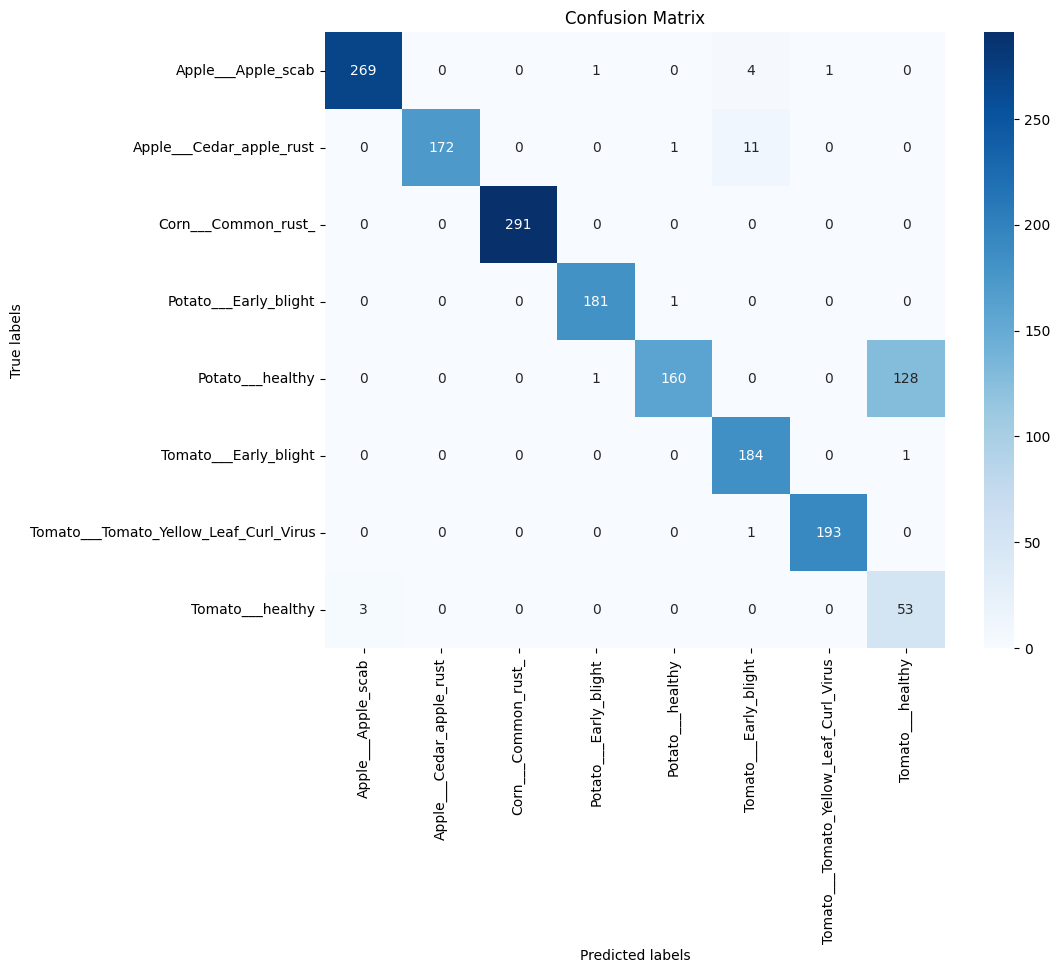

In [128]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Extract actual and predicted labels
actual = [item[0].split('___')[0] + '___' + item[0].split('___')[1].split('.')[0] for item in result_new]
predicted = [list(item[1])[0] for item in result_new]

# Create a confusion matrix
labels = sorted(set(actual + predicted))  # Get all unique labels
conf_matrix = confusion_matrix(actual, predicted, labels=labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [131]:
plt.savefig("cm")

<Figure size 640x480 with 0 Axes>

In [ ]:
results[:10]

In [ ]:
#ONLY RUN THIS AFTER WE HAVE LABELLED THE TESTING FOLDER! THIS RENAMES ALL IMAGES TO .jpg INSTEAD OF .JPG


import os

# Path to the directory containing images
directory_path = '/home/datascience/kaggle/test/test'

# List all files in the directory
all_files = os.listdir(directory_path)

# Iterate over each file
for filename in all_files:
    # Check if the file extension is .JPG (case-sensitive)
    if filename.endswith(".JPG"):
        # Create the full old and new file paths
        old_file_path = os.path.join(directory_path, filename)
        new_file_path = os.path.join(directory_path, filename.replace(".JPG", ".jpg"))
        
        # Rename the file
        os.rename(old_file_path, new_file_path)

print("Renaming complete.")


In [ ]:
#checks if any files are not in proper format

for f in all_files:
    if not f.endswith(".jpg"):
        print(f"Non-JPG file: {f}")
